In [13]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
from torch.optim import LBFGS, Adam
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm
import pickle

In [14]:
from models import PINN
from utils import get_data, init_weights, predict, l1_relative_error, l2_relative_error
from visualization import project_trajectories, generate_loss_grid, plot_trajectories, compute_hessian_directions, plot_landscape

# Set global variables

In [15]:
# set display parameters
%config InlineBackend.figure_format = 'retina'

# set seed
seed = 3
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# set device
device = 'cuda:7'

# Set experiment parameters

We define the convection problem (domain, $\beta$ value) and the model architecture.

In [16]:
x_range = [0, 2*np.pi]
t_range = [0, 1]
x_num =  101
t_num = 101
beta = 30

num_layer = 4
num_neuron = 100 # 512

num_epochs = 1000

In [17]:
# define loss function for convection problem
def loss_func(x, t, outputs):
  x_res, x_left, x_right, x_upper, x_lower = x
  t_res, t_left, t_right, t_upper, t_lower = t
  outputs_res, outputs_left, outputs_right, outputs_upper, outputs_lower = outputs

  u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
  u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

  # loss_res = torch.mean((u_t + beta * u_x) ** 2)
  # loss_bc = torch.mean((outputs_upper - outputs_lower) ** 2)
  # loss_ic = torch.mean((outputs_left[:,0] - torch.sin(x_left[:,0])) ** 2)

  loss_res = nn.HuberLoss()(u_t + beta * u_x, torch.zeros_like(u_t))
  loss_bc = nn.HuberLoss()(outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
  loss_ic = nn.HuberLoss()(outputs_left[:,0], torch.sin(x_left[:,0]))

  loss = loss_res + loss_bc + loss_ic

  return loss

# Train the model (PINN)

In [18]:
# generate data
x, t = get_data(x_range, t_range, x_num, t_num, device=device)
data = (x, t)

# define model and optimizer
model = PINN(in_dim=2, hidden_dim=num_neuron, out_dim=1, num_layer=num_layer).to(device)
model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-3)

# start training process
loss_hist = []
weights_hist = []
for i in tqdm(range(num_epochs)):
  # keep track of model parameters
  weights = [p.data.clone() for p in model.parameters()]
  weights_hist.append(weights)

  # train the model
  model.train()
  def closure():
    outputs = predict(x, t, model)
    loss = loss_func(x, t, outputs)
    optim.zero_grad()
    loss.backward()

    return loss
  optim.step(closure)

  # record total loss
  model.eval()
  outputs = predict(x, t, model)
  loss = loss_func(x, t, outputs)

  loss_hist.append(loss.item())

# record the final model parameters
final_weights = [p.data.clone() for p in model.parameters()]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


Text(0, 0.5, 'total loss')

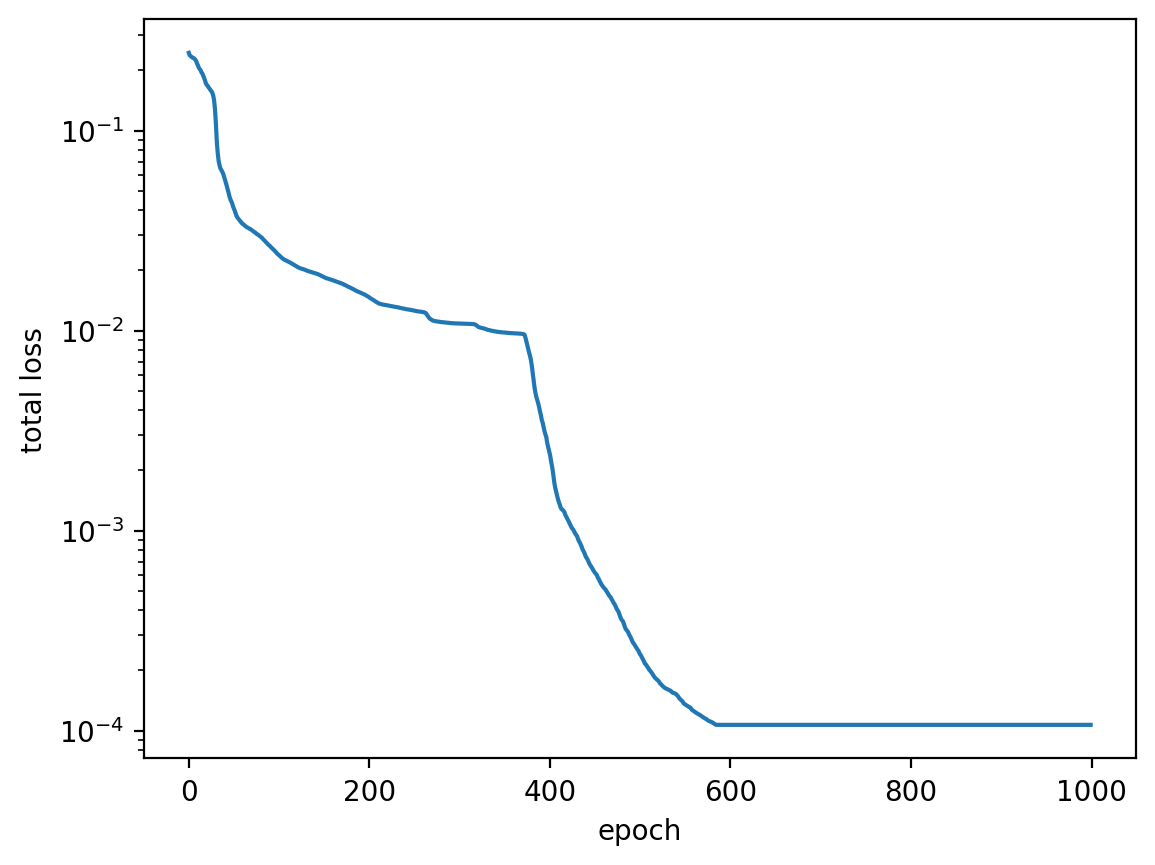

In [19]:
# plot log total loss
plt.semilogy(loss_hist)
plt.xlabel('epoch')
plt.ylabel('total loss')

In [20]:
# compute relative errors
# here we only take residual predictions (since residual set contains all the grid points)
with torch.no_grad():
  predictions = predict(x, t, model)[0].cpu().detach().numpy()
targets = np.sin(x[0].cpu().detach().numpy() - beta * t[0].cpu().detach().numpy())
l1re = l1_relative_error(predictions, targets)
l2re = l2_relative_error(predictions, targets)
print(f'l1re: {l1re:.3f}/ l2re: {l2re:.3f}')

l1re: 0.025/ l2re: 0.031


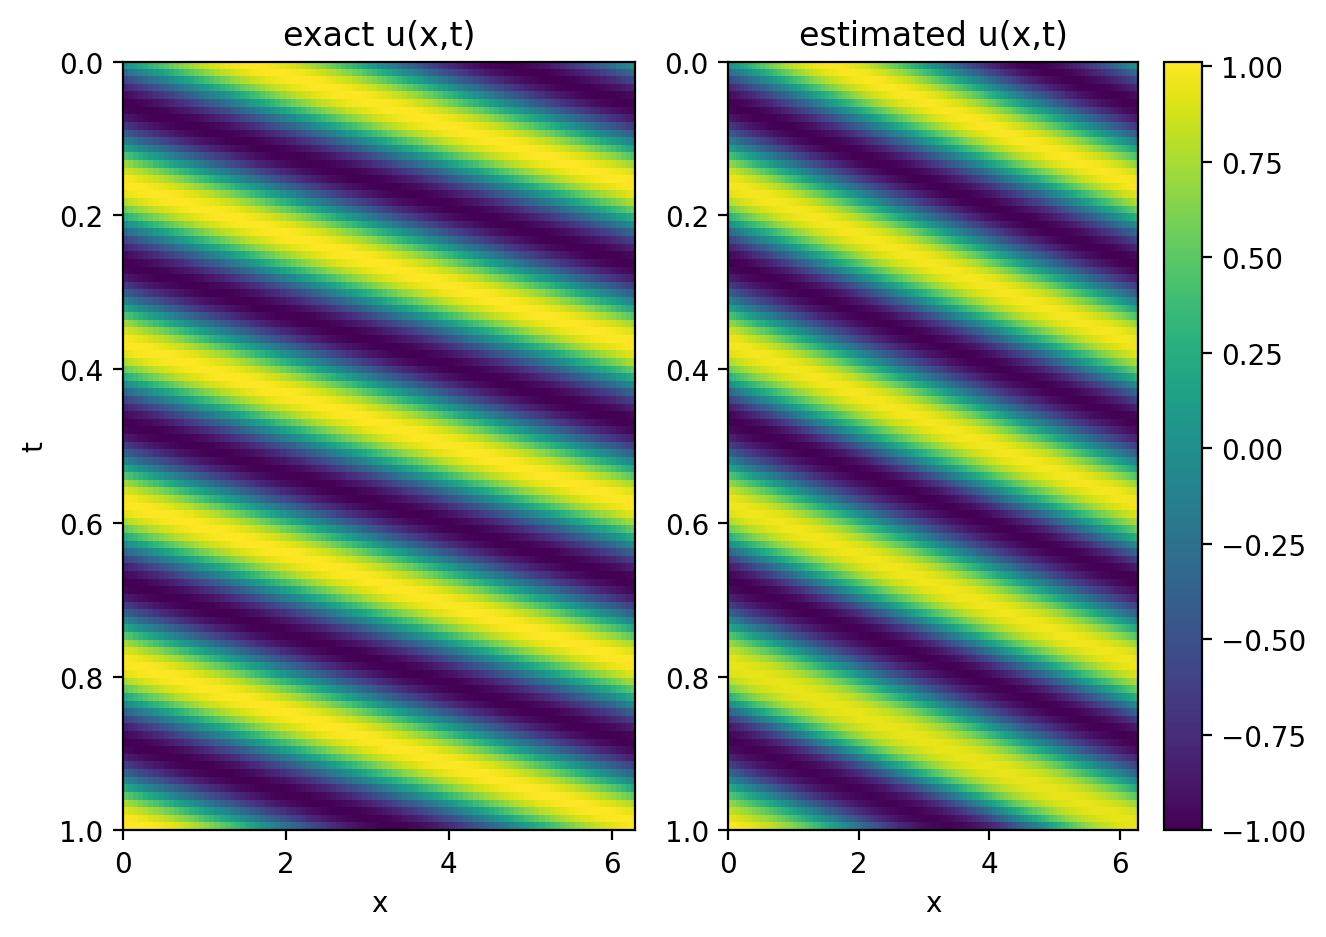

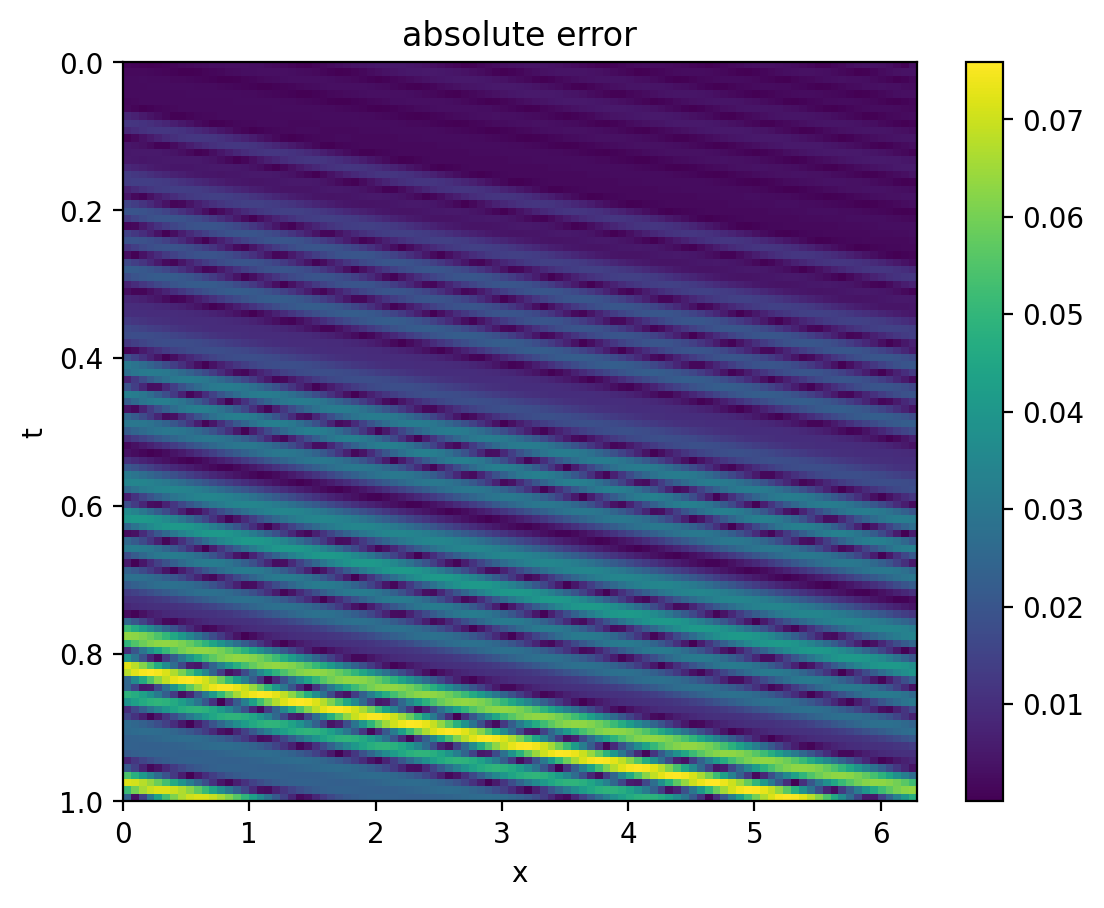

In [21]:
# visually compare predictions and ground truths
plt.subplot(1, 2, 1)
plt.imshow(targets.reshape(x_num,t_num), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('exact u(x,t)')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.imshow(predictions.reshape(x_num,t_num), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.title('estimated u(x,t)')
plt.tight_layout()
plt.colorbar()

plt.figure()
plt.imshow(np.abs(targets.reshape(x_num,t_num) - predictions.reshape(x_num,t_num)), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('absolute error')
plt.colorbar()

# Visualize trajectories

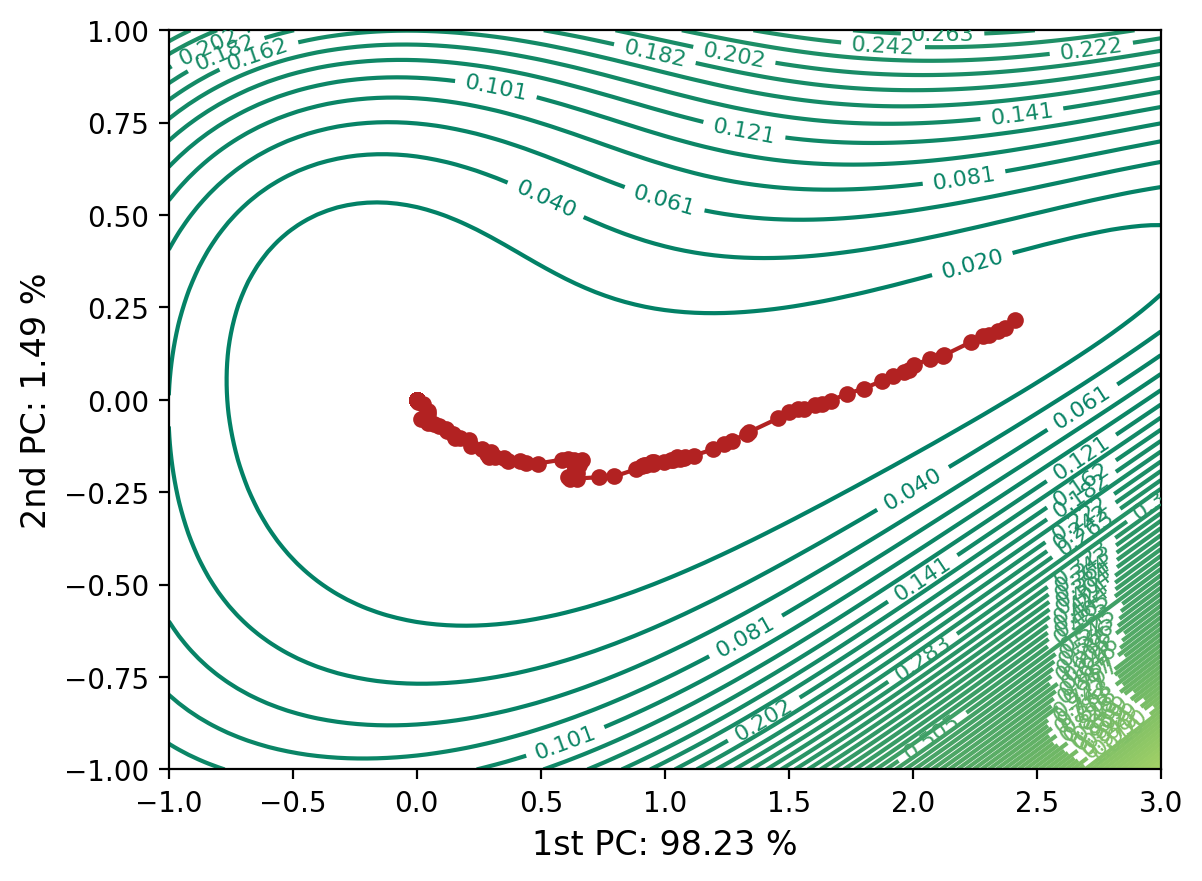

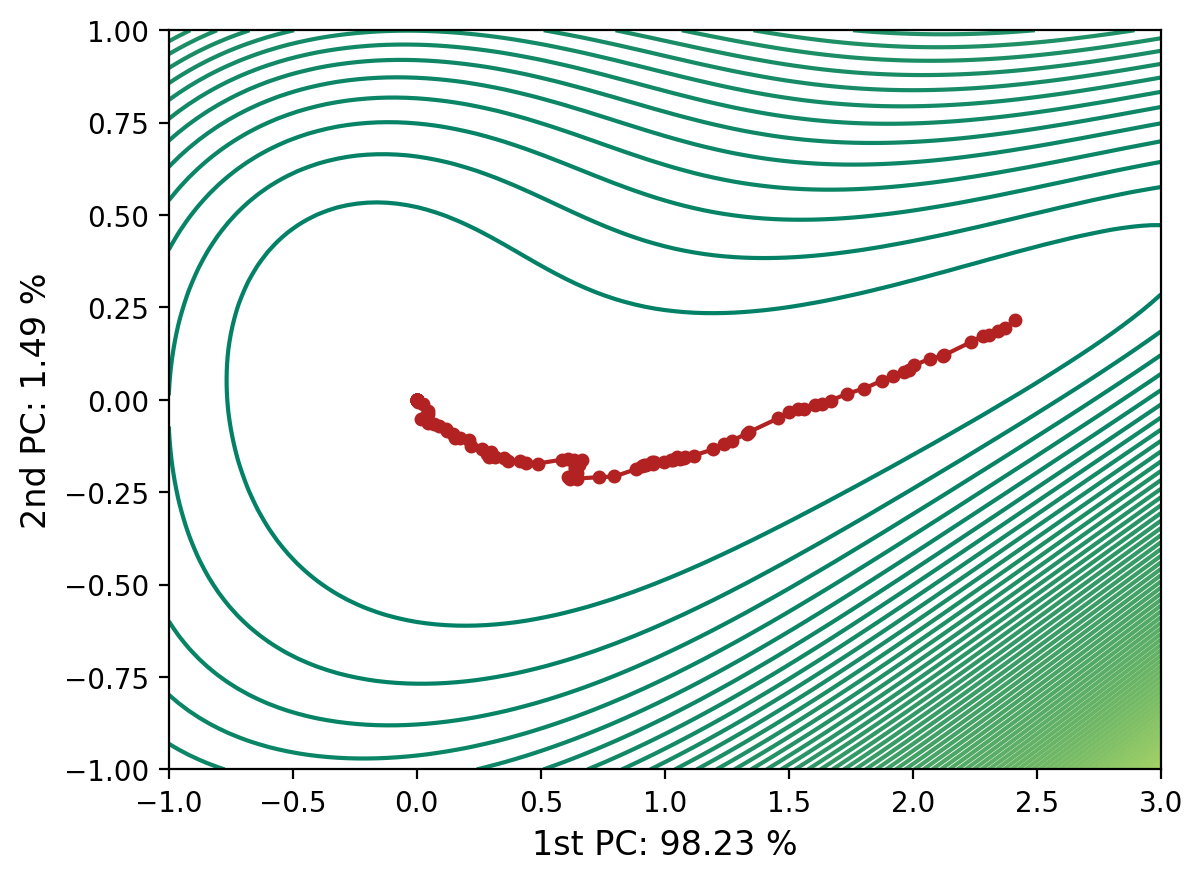

In [22]:
# compute first two principal components of the weight differences
starting_epoch = 500
ending_epoch = 800
directions, variance_ratios, trajectory_coords = project_trajectories(weights_hist[starting_epoch:ending_epoch], final_weights, device=device)

# adjust plotting range
trajectory_coords_x = trajectory_coords[0,:]
trajectory_coords_y = trajectory_coords[1,:]

xcoord_min = min(-1, np.floor(np.min(trajectory_coords_x)))
xcoord_max = max(1, np.ceil(np.max(trajectory_coords_x)))

ycoord_min = min(-1, np.floor(np.min(trajectory_coords_y)))
ycoord_max = max(1, np.ceil(np.max(trajectory_coords_y)))

sample_range_x = [xcoord_min, xcoord_max]
sample_range_y = [ycoord_min, ycoord_max]

# compute loss on the grid
loss_grid, coord_grid = generate_loss_grid(directions, final_weights, data, predict, loss_func, model, device=device, num_samples_x=100, num_samples_y=100, sample_range_x=sample_range_x, sample_range_y=sample_range_y, log_scale=False)

# make plot
plot_trajectories(loss_grid, coord_grid, trajectory_coords, variance_ratios, countour_range=None, num_contours=100, save_file="trajectories", animate=True, animation_format='apng')

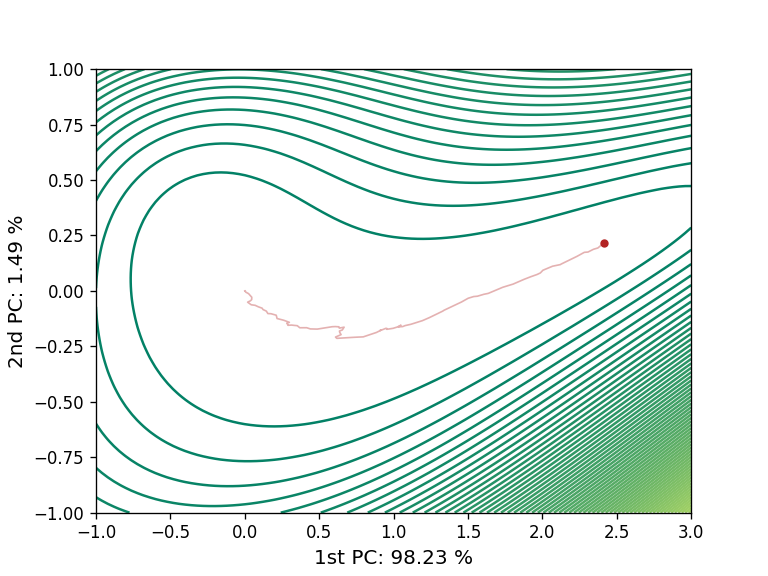

In [23]:
# display animated trajectories
Image(open('trajectories.apng','rb').read())

# Visualize landscape (using Hessian information)

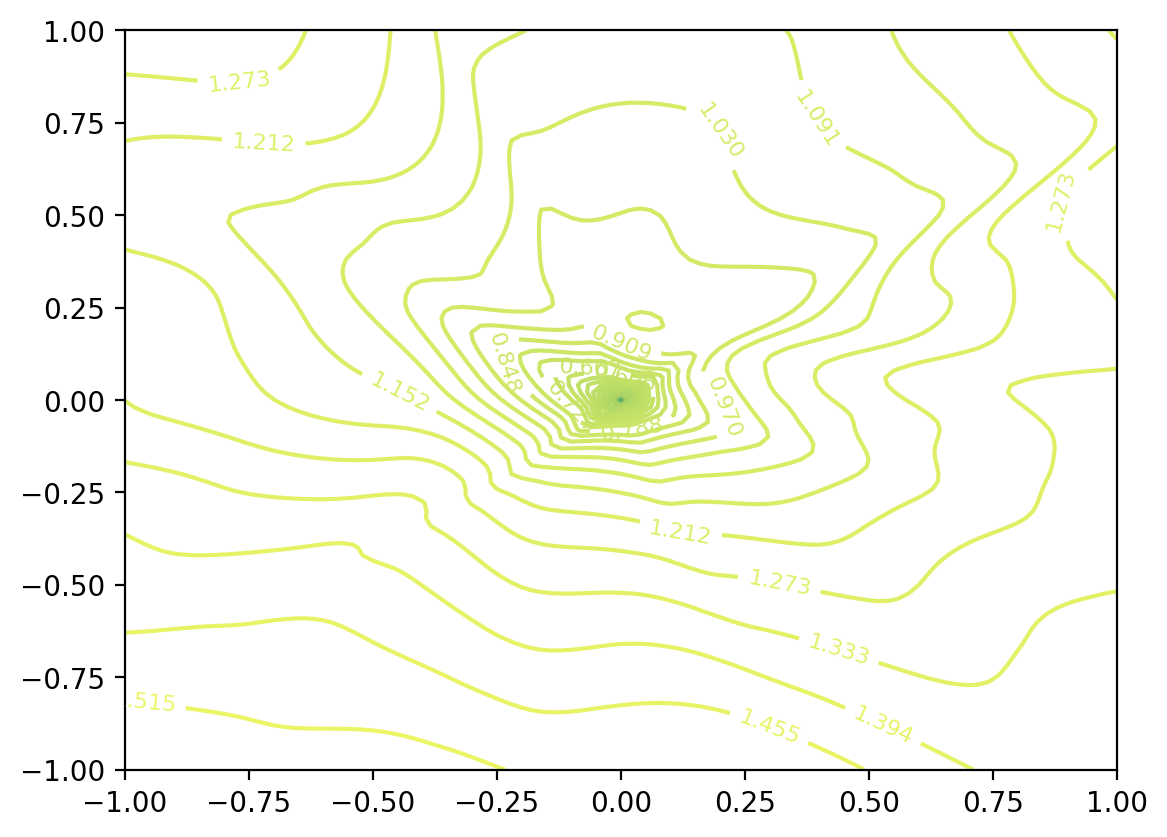

In [24]:
# compute top two eigenvectors of the Hessian
eig_vecs = compute_hessian_directions(data, predict, loss_func, model, device=device)

# compute loss on the grid
loss_grid, coord_grid = generate_loss_grid(eig_vecs, final_weights, data, predict, loss_func, model, device=device, num_samples_x=100, num_samples_y=100, sample_range_x=[-1,1], sample_range_y=[-1,1], log_scale=True)

# make plot
plot_landscape(loss_grid, coord_grid, countour_range=None, num_contours=100, save_file="landscape")